## Grad-CAM on ResNet

Interpretability of AI model is a major important in the critical fields, such as, healthcare. They allow ML engineers to debug the model and experts to verify whether the model is actually looking for relevant features. 

CNN based Salient maps has been popular techinque to introduce interpretability in computer vision task, such as image classification. An instance of the technique, GradCAM (Gradient-weighted Class Activation Map), is a popular algorithm used in CV to visualize regions on an input image that are salient for particular predition made by the CNN model. 

In classification task, such as this Chest X-Ray one, it is important to find which region of the Chest X-Ray contributed to the decision per input image.So, let's try it out.

In [533]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sys
from PIL import Image
from torch import nn
from torchvision import transforms

sys.path.append("..")

torch.manual_seed(0)

importing required user-defined utility functions.

In [534]:
from src.models.resnet_transfer import return_model
from src.utils.constants import MODEL_DIR, IMAGE_SIZE
from src.utils.helper import return_pred_and_prob, preprocess_image

let's load the resnet model.

In [535]:
resnet_model = return_model()

for param in resnet_model.parameters():
        param.requires_grad = True

And also load the pretrained model's weights.

In [536]:
model_weight = torch.load(MODEL_DIR / "resnet_transfer.pth")["model_state_dict"]
resnet_model.load_state_dict(model_weight)
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Grad-CAM (Gradient-weighted Class Activation Mapping)

Uses Gradient of last convolution layer to produce a coarse localization map highlighting the important regions in image for predicting the target.

Let's define the function to compute the Grad-CAM map that we will be overlaying upon the input image.

For computing the map, the author provides the steps as:
1. First, compute the gradient of the last conv layer.
2. Second, global average pool the gradients to obtain the neuron importance weights. This wieght represent sa partial linearization of deep network downstream, and capture "importance" of feature map for a target class.

<center><img src="../asset/Gradcam_eq1.png", width=300></center>

3. Finally perform ReLU to only get features with +ve influence on the class.

<center><img src="../asset/Gradcam_eq2.png", width=300></center>

In [569]:
def compute_gradcam(model, input_image, target_class):
    
    # Get the last convolutional layer
    last_conv_layer = model.layer4[-1].conv2

    # define hook required to get the output from the conv layer (pytorch)
    def hook_fn(module, input, output):
        # Store the output of the intermediate layer
        hook_fn.output = output
        
    # register the hook    
    hook_handle = last_conv_layer.register_forward_hook(hook_fn)
    
    # run the prediction process
    model.zero_grad()
    output = model(input_image)
    pred, prob = return_pred_and_prob(nn.Sigmoid()(output))
    print(f"Model Prediction = {pred}; with probability {prob:2f}")
    
    # compute the gradients
    output.backward()
    
    gradients = last_conv_layer.weight.grad 
    # since we are using sigmoid activation, we require -ve gradient for the -ve class (normal).
    # the negation can also be used to provide counterfactual explanations.
    if target_class==0:
        gradients *= -1
    
    # compute the global average pooling of the gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    # get the activations from the conv layer
    activations = hook_fn.output
    hook_handle.remove()
    
    # perform linear combination of gradient and the activation (weighting)
    for i in range(gradients.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).detach().numpy().squeeze()
    
    # perform ReLU activation as suggested by the paper.
    heatmap = np.maximum(heatmap, 0)
    
    # normalize the heatmap
    heatmap /= np.max(heatmap) + np.finfo(np.float32).eps
    
    return heatmap

Next, we also require a function to visualize the gradcam. We will:

1. First, Load the image and perform preprocessing on it.
2. Next, compute the class-discriminative localization map.
3. Finally, perform postprocessing such as resizing and coloring and overlay it over the input image.

In [570]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import PIL

def visualize_gradcam(input_image_path, target_class):
    
    # load the input image
    image = Image.open(input_image_path).convert("RGB")
    preprocessed_image = preprocess_image(input_image_path)
        
    # Generate GradCAM heatmap
    heatmap = compute_gradcam(resnet_model, preprocessed_image, target_class)

    overlay = to_pil_image(heatmap, mode='F')\
        .resize(image.size, resample=PIL.Image.BICUBIC)
    
    # apply any colormap you want
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

    # Display the input image and GradCAM heatmap
    _, ax = plt.subplots()
    ax.axis('off') # removes the axis markers
    
    # First plot the original image and then the map
    ax.imshow(image)
    ax.imshow(overlay, alpha=0.4)
    plt.show()


Let's try out the GradCAM on 1 sample each  

In [587]:
positive_sample = "../data/chest_xray/test/PNEUMONIA/person15_virus_46.jpeg"


Model Prediction = Normal; with probability 0.910775


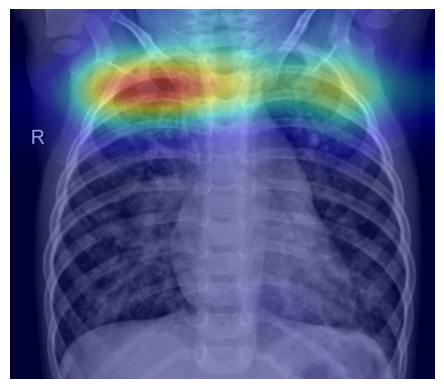

In [588]:
visualize_gradcam(positive_sample, target_class=1)

In [581]:
negative_sample = "../data/chest_xray/test/NORMAL/NORMAL2-IM-0373-0001.jpeg"

Model Prediction = Pneumonia; with probability 0.780454


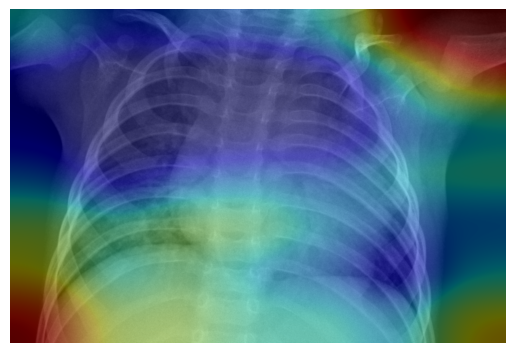

In [582]:
visualize_gradcam(negative_sample, target_class=0)

I leave validation of the explanations to the future me. For now, I will be concluding this notebook with only the implementation of Grad-CAM. 